## Imports

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [2]:
RANDOM_SEED = 1
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
NUM_EPOCHS = 20

RESOLUTION = 200
NUM_FEATURES = RESOLUTION*RESOLUTION
NUM_CLASSES = 66

DEVICE = "cuda:0"
GRAYSCALE = False

In [4]:
transform = transforms.Compose([
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor()
])

path = 'CV_data/Extracted_dataset_input_combined'
dataset = datasets.ImageFolder(root=path, transform=transform)


# Get class to index mapping
class_to_idx = dataset.class_to_idx

# Define index to class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training set and test set
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Labels:', labels)
    break


Image batch dimensions: torch.Size([32, 3, 200, 200])
Image label dimensions: torch.Size([32])
Labels: tensor([21,  9, 12,  0, 50, 42, 65, 41, 44, 61, 44, 45, 13, 20, 39, 12, 62,  7,
        52, 24, 20,  0, 37, 29,  0, 35,  9, 54, 40, 12, 62, 25])


In [5]:
from collections import Counter

train_classes = [dataset.targets[i] for i in train_dataset.indices]
class_weights = 1 / torch.tensor(list(dict(sorted(dict(Counter(train_classes)).items())).values()))
class_weights

tensor([0.0003, 0.0017, 0.0029, 0.0014, 0.0008, 0.0023, 0.0005, 0.0016, 0.0149,
        0.0016, 0.0172, 0.0017, 0.0004, 0.0030, 0.0078, 0.0013, 0.0075, 0.0012,
        0.0152, 0.0025, 0.0032, 0.0031, 0.0169, 0.0033, 0.0009, 0.0013, 0.0006,
        0.0026, 0.0026, 0.0026, 0.0022, 0.0028, 0.0075, 0.0017, 0.0152, 0.0027,
        0.0025, 0.0013, 0.0070, 0.0032, 0.0013, 0.0009, 0.0024, 0.0027, 0.0008,
        0.0002, 0.0152, 0.0063, 0.0012, 0.0012, 0.0073, 0.0023, 0.0011, 0.0025,
        0.0179, 0.0026, 0.0025, 0.0139, 0.0156, 0.0026, 0.0069, 0.0022, 0.0006,
        0.0019, 0.0154, 0.0016, 0.0112])

In [6]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 32
Epoch: 2 | Batch index: 0 | Batch size: 32


# Model

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


In [8]:
torch.manual_seed(RANDOM_SEED)

model = resnet18(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [9]:
def compute_accuracy(model, data_loader, device, mode="train"):
    correct_pred, num_examples = 0, 0
    for batch_idx, (features, targets) in tqdm(enumerate(data_loader)):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
        if not batch_idx % 50:
            accuracy = correct_pred.float() / num_examples * 100
            with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-{mode}-accuracy.csv', 'a') as fp:
                fp.write(f"{epoch+1}, {batch_idx}, {accuracy}\n")
            correct_pred, num_examples = 0, 0



In [10]:
def compute_loss(model, data_loader, class_weights, device, mode="val"):
    losses = []
    dataset_len = len(data_loader)
    for batch_idx, (features, targets) in tqdm(enumerate(data_loader)):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        class_weights = class_weights.to(DEVICE)
            
        logits, _ = model(features)
        loss = F.cross_entropy(logits, targets, weight=class_weights)
        losses.append(loss)
        
        if not batch_idx % 50:
            mean_loss = sum(losses) / len(losses)
            with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-{mode}-loss.csv', 'a') as fp:
                fp.write(f"{epoch+1}, {batch_idx}, {mean_loss}\n")
            losses.clear()

In [11]:
model_name = "04-model"

## Training

In [11]:

start_time = time.time()

for epoch in range(NUM_EPOCHS):
        model.train()
        losses = []
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            class_weights = class_weights.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, weight=class_weights)
            losses.append(loss)

            optimizer.zero_grad()

            loss.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx,
                         len(train_loader), loss))

                mean_loss = sum(losses) / len(losses)
                with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-train-loss.csv', 'a') as fp:
                    fp.write(f"{epoch+1}, {batch_idx}, {mean_loss}\n")
                losses.clear()


        model.eval()
        with torch.set_grad_enabled(False): # save memory during inference
            compute_accuracy(model, train_loader, device=DEVICE, mode="train")
            compute_loss(model, val_loader, class_weights, device=DEVICE, mode="val")
            compute_accuracy(model, val_loader, device=DEVICE, mode="val")

        file_path = f'CV_data/models/{model_name}-{LEARNING_RATE}-epoch{epoch+1}.pth'
        torch.save(model.state_dict(), file_path)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 0000/1284 | Cost: 4.3589


/data/leuven/354/vsc35486/miniconda3/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 001/020 | Batch 0050/1284 | Cost: 3.9593
Epoch: 001/020 | Batch 0100/1284 | Cost: 4.0111
Epoch: 001/020 | Batch 0150/1284 | Cost: 3.9041
Epoch: 001/020 | Batch 0200/1284 | Cost: 3.3668
Epoch: 001/020 | Batch 0250/1284 | Cost: 2.9288
Epoch: 001/020 | Batch 0300/1284 | Cost: 3.3802
Epoch: 001/020 | Batch 0350/1284 | Cost: 2.5156
Epoch: 001/020 | Batch 0400/1284 | Cost: 2.2874
Epoch: 001/020 | Batch 0450/1284 | Cost: 2.5377
Epoch: 001/020 | Batch 0500/1284 | Cost: 2.5965
Epoch: 001/020 | Batch 0550/1284 | Cost: 2.2849
Epoch: 001/020 | Batch 0600/1284 | Cost: 2.4050
Epoch: 001/020 | Batch 0650/1284 | Cost: 1.7361
Epoch: 001/020 | Batch 0700/1284 | Cost: 1.8237
Epoch: 001/020 | Batch 0750/1284 | Cost: 1.8348
Epoch: 001/020 | Batch 0800/1284 | Cost: 1.8487
Epoch: 001/020 | Batch 0850/1284 | Cost: 1.7696
Epoch: 001/020 | Batch 0900/1284 | Cost: 1.9234
Epoch: 001/020 | Batch 0950/1284 | Cost: 1.7512
Epoch: 001/020 | Batch 1000/1284 | Cost: 1.0668
Epoch: 001/020 | Batch 1050/1284 | Cost:

1284it [01:51, 11.52it/s]
428it [00:36, 11.70it/s]
428it [00:36, 11.71it/s]


Time elapsed: 5.34 min
Epoch: 002/020 | Batch 0000/1284 | Cost: 1.3750
Epoch: 002/020 | Batch 0050/1284 | Cost: 1.6366
Epoch: 002/020 | Batch 0100/1284 | Cost: 1.1595
Epoch: 002/020 | Batch 0150/1284 | Cost: 1.2513
Epoch: 002/020 | Batch 0200/1284 | Cost: 0.9601
Epoch: 002/020 | Batch 0250/1284 | Cost: 0.9070
Epoch: 002/020 | Batch 0300/1284 | Cost: 1.2602
Epoch: 002/020 | Batch 0350/1284 | Cost: 1.2062
Epoch: 002/020 | Batch 0400/1284 | Cost: 1.2148
Epoch: 002/020 | Batch 0450/1284 | Cost: 1.6006
Epoch: 002/020 | Batch 0500/1284 | Cost: 1.0081
Epoch: 002/020 | Batch 0550/1284 | Cost: 1.3204
Epoch: 002/020 | Batch 0600/1284 | Cost: 1.0442
Epoch: 002/020 | Batch 0650/1284 | Cost: 1.0239
Epoch: 002/020 | Batch 0700/1284 | Cost: 0.5256
Epoch: 002/020 | Batch 0750/1284 | Cost: 1.0207
Epoch: 002/020 | Batch 0800/1284 | Cost: 0.9980
Epoch: 002/020 | Batch 0850/1284 | Cost: 0.5990
Epoch: 002/020 | Batch 0900/1284 | Cost: 1.5126
Epoch: 002/020 | Batch 0950/1284 | Cost: 0.6893
Epoch: 002/020 | 

1284it [02:07, 10.09it/s]
428it [00:37, 11.57it/s]
428it [00:36, 11.66it/s]


Time elapsed: 11.08 min
Epoch: 003/020 | Batch 0000/1284 | Cost: 1.0458
Epoch: 003/020 | Batch 0050/1284 | Cost: 0.3725
Epoch: 003/020 | Batch 0100/1284 | Cost: 0.6663
Epoch: 003/020 | Batch 0150/1284 | Cost: 0.7052
Epoch: 003/020 | Batch 0200/1284 | Cost: 0.9669
Epoch: 003/020 | Batch 0250/1284 | Cost: 0.4872
Epoch: 003/020 | Batch 0300/1284 | Cost: 1.4892
Epoch: 003/020 | Batch 0350/1284 | Cost: 0.6348
Epoch: 003/020 | Batch 0400/1284 | Cost: 0.4200
Epoch: 003/020 | Batch 0450/1284 | Cost: 0.5053
Epoch: 003/020 | Batch 0500/1284 | Cost: 0.6801
Epoch: 003/020 | Batch 0550/1284 | Cost: 0.4117
Epoch: 003/020 | Batch 0600/1284 | Cost: 0.4743
Epoch: 003/020 | Batch 0650/1284 | Cost: 0.9864
Epoch: 003/020 | Batch 0700/1284 | Cost: 0.4554
Epoch: 003/020 | Batch 0750/1284 | Cost: 0.7352
Epoch: 003/020 | Batch 0800/1284 | Cost: 0.2880
Epoch: 003/020 | Batch 0850/1284 | Cost: 0.6726
Epoch: 003/020 | Batch 0900/1284 | Cost: 0.6380
Epoch: 003/020 | Batch 0950/1284 | Cost: 0.4704
Epoch: 003/020 |

1284it [01:54, 11.24it/s]
428it [00:36, 11.73it/s]
428it [00:35, 11.94it/s]


Time elapsed: 16.45 min
Epoch: 004/020 | Batch 0000/1284 | Cost: 0.4442
Epoch: 004/020 | Batch 0050/1284 | Cost: 0.2262
Epoch: 004/020 | Batch 0100/1284 | Cost: 0.2805
Epoch: 004/020 | Batch 0150/1284 | Cost: 1.1292
Epoch: 004/020 | Batch 0200/1284 | Cost: 0.1648
Epoch: 004/020 | Batch 0250/1284 | Cost: 0.3185
Epoch: 004/020 | Batch 0300/1284 | Cost: 0.6803
Epoch: 004/020 | Batch 0350/1284 | Cost: 0.3077
Epoch: 004/020 | Batch 0400/1284 | Cost: 0.1827
Epoch: 004/020 | Batch 0450/1284 | Cost: 0.1036
Epoch: 004/020 | Batch 0500/1284 | Cost: 0.3905
Epoch: 004/020 | Batch 0550/1284 | Cost: 0.4338
Epoch: 004/020 | Batch 0600/1284 | Cost: 0.2784
Epoch: 004/020 | Batch 0650/1284 | Cost: 0.1987
Epoch: 004/020 | Batch 0700/1284 | Cost: 0.1216
Epoch: 004/020 | Batch 0750/1284 | Cost: 0.5614
Epoch: 004/020 | Batch 0800/1284 | Cost: 0.2629
Epoch: 004/020 | Batch 0850/1284 | Cost: 0.2173
Epoch: 004/020 | Batch 0900/1284 | Cost: 0.2132
Epoch: 004/020 | Batch 0950/1284 | Cost: 0.3396
Epoch: 004/020 |

1284it [01:52, 11.39it/s]
428it [00:39, 10.73it/s]
428it [00:39, 10.73it/s]


Time elapsed: 21.88 min
Epoch: 005/020 | Batch 0000/1284 | Cost: 0.2091
Epoch: 005/020 | Batch 0050/1284 | Cost: 0.5553
Epoch: 005/020 | Batch 0100/1284 | Cost: 0.4875
Epoch: 005/020 | Batch 0150/1284 | Cost: 0.3790
Epoch: 005/020 | Batch 0200/1284 | Cost: 0.3346
Epoch: 005/020 | Batch 0250/1284 | Cost: 0.4872
Epoch: 005/020 | Batch 0300/1284 | Cost: 0.1142
Epoch: 005/020 | Batch 0350/1284 | Cost: 0.2002
Epoch: 005/020 | Batch 0400/1284 | Cost: 0.2264
Epoch: 005/020 | Batch 0450/1284 | Cost: 0.6128
Epoch: 005/020 | Batch 0500/1284 | Cost: 0.1916
Epoch: 005/020 | Batch 0550/1284 | Cost: 0.1193
Epoch: 005/020 | Batch 0600/1284 | Cost: 0.2174
Epoch: 005/020 | Batch 0650/1284 | Cost: 0.2471
Epoch: 005/020 | Batch 0700/1284 | Cost: 0.6695
Epoch: 005/020 | Batch 0750/1284 | Cost: 0.5643
Epoch: 005/020 | Batch 0800/1284 | Cost: 0.8113
Epoch: 005/020 | Batch 0850/1284 | Cost: 0.1526
Epoch: 005/020 | Batch 0900/1284 | Cost: 0.5197
Epoch: 005/020 | Batch 0950/1284 | Cost: 0.1501
Epoch: 005/020 |

1284it [01:51, 11.51it/s]
428it [00:35, 12.10it/s]
428it [00:35, 11.92it/s]


Time elapsed: 27.27 min
Epoch: 006/020 | Batch 0000/1284 | Cost: 0.1324
Epoch: 006/020 | Batch 0050/1284 | Cost: 0.2773
Epoch: 006/020 | Batch 0100/1284 | Cost: 0.1011
Epoch: 006/020 | Batch 0150/1284 | Cost: 0.2515
Epoch: 006/020 | Batch 0200/1284 | Cost: 0.0917
Epoch: 006/020 | Batch 0250/1284 | Cost: 0.2010
Epoch: 006/020 | Batch 0300/1284 | Cost: 0.1452
Epoch: 006/020 | Batch 0350/1284 | Cost: 0.0526
Epoch: 006/020 | Batch 0400/1284 | Cost: 0.1628
Epoch: 006/020 | Batch 0450/1284 | Cost: 0.1457
Epoch: 006/020 | Batch 0500/1284 | Cost: 0.0907
Epoch: 006/020 | Batch 0550/1284 | Cost: 0.2082
Epoch: 006/020 | Batch 0600/1284 | Cost: 0.3310
Epoch: 006/020 | Batch 0650/1284 | Cost: 0.1657
Epoch: 006/020 | Batch 0700/1284 | Cost: 0.2198
Epoch: 006/020 | Batch 0750/1284 | Cost: 0.2718
Epoch: 006/020 | Batch 0800/1284 | Cost: 0.9392
Epoch: 006/020 | Batch 0850/1284 | Cost: 0.2288
Epoch: 006/020 | Batch 0900/1284 | Cost: 0.3660
Epoch: 006/020 | Batch 0950/1284 | Cost: 0.6658
Epoch: 006/020 |

1284it [01:49, 11.71it/s]
428it [00:35, 11.98it/s]
428it [00:37, 11.39it/s]


Time elapsed: 32.53 min
Epoch: 007/020 | Batch 0000/1284 | Cost: 0.1835
Epoch: 007/020 | Batch 0050/1284 | Cost: 0.2047
Epoch: 007/020 | Batch 0100/1284 | Cost: 0.0811
Epoch: 007/020 | Batch 0150/1284 | Cost: 0.0304
Epoch: 007/020 | Batch 0200/1284 | Cost: 0.0281
Epoch: 007/020 | Batch 0250/1284 | Cost: 0.3703
Epoch: 007/020 | Batch 0300/1284 | Cost: 0.0933
Epoch: 007/020 | Batch 0350/1284 | Cost: 0.2040
Epoch: 007/020 | Batch 0400/1284 | Cost: 0.0431
Epoch: 007/020 | Batch 0450/1284 | Cost: 0.2700
Epoch: 007/020 | Batch 0500/1284 | Cost: 0.0505
Epoch: 007/020 | Batch 0550/1284 | Cost: 0.3034
Epoch: 007/020 | Batch 0600/1284 | Cost: 0.0756
Epoch: 007/020 | Batch 0650/1284 | Cost: 0.2060
Epoch: 007/020 | Batch 0700/1284 | Cost: 0.1081
Epoch: 007/020 | Batch 0750/1284 | Cost: 0.2434
Epoch: 007/020 | Batch 0800/1284 | Cost: 0.1810
Epoch: 007/020 | Batch 0850/1284 | Cost: 0.0373
Epoch: 007/020 | Batch 0900/1284 | Cost: 0.1055
Epoch: 007/020 | Batch 0950/1284 | Cost: 0.4930
Epoch: 007/020 |

1284it [01:49, 11.75it/s]
428it [00:35, 12.02it/s]
428it [00:35, 12.07it/s]


Time elapsed: 37.76 min
Epoch: 008/020 | Batch 0000/1284 | Cost: 0.0674
Epoch: 008/020 | Batch 0050/1284 | Cost: 0.0764
Epoch: 008/020 | Batch 0100/1284 | Cost: 0.0335
Epoch: 008/020 | Batch 0150/1284 | Cost: 0.0888
Epoch: 008/020 | Batch 0200/1284 | Cost: 0.3276
Epoch: 008/020 | Batch 0250/1284 | Cost: 0.1021
Epoch: 008/020 | Batch 0300/1284 | Cost: 0.3720
Epoch: 008/020 | Batch 0350/1284 | Cost: 0.0591
Epoch: 008/020 | Batch 0400/1284 | Cost: 0.2078
Epoch: 008/020 | Batch 0450/1284 | Cost: 0.2695
Epoch: 008/020 | Batch 0500/1284 | Cost: 0.8093
Epoch: 008/020 | Batch 0550/1284 | Cost: 0.3644
Epoch: 008/020 | Batch 0600/1284 | Cost: 0.1741
Epoch: 008/020 | Batch 0650/1284 | Cost: 0.2743
Epoch: 008/020 | Batch 0700/1284 | Cost: 0.1239
Epoch: 008/020 | Batch 0750/1284 | Cost: 0.1267
Epoch: 008/020 | Batch 0800/1284 | Cost: 0.3677
Epoch: 008/020 | Batch 0850/1284 | Cost: 0.1206
Epoch: 008/020 | Batch 0900/1284 | Cost: 0.0674
Epoch: 008/020 | Batch 0950/1284 | Cost: 0.1740
Epoch: 008/020 |

1284it [01:47, 11.90it/s]
428it [00:35, 12.08it/s]
428it [00:35, 11.94it/s]


Time elapsed: 42.97 min
Epoch: 009/020 | Batch 0000/1284 | Cost: 0.1738
Epoch: 009/020 | Batch 0050/1284 | Cost: 0.0395
Epoch: 009/020 | Batch 0100/1284 | Cost: 0.0499
Epoch: 009/020 | Batch 0150/1284 | Cost: 0.0219
Epoch: 009/020 | Batch 0200/1284 | Cost: 0.0333
Epoch: 009/020 | Batch 0250/1284 | Cost: 0.2111
Epoch: 009/020 | Batch 0300/1284 | Cost: 0.0352
Epoch: 009/020 | Batch 0350/1284 | Cost: 1.3002
Epoch: 009/020 | Batch 0400/1284 | Cost: 0.1861
Epoch: 009/020 | Batch 0450/1284 | Cost: 0.0319
Epoch: 009/020 | Batch 0500/1284 | Cost: 0.0532
Epoch: 009/020 | Batch 0550/1284 | Cost: 0.2265
Epoch: 009/020 | Batch 0600/1284 | Cost: 0.0468
Epoch: 009/020 | Batch 0650/1284 | Cost: 0.0658
Epoch: 009/020 | Batch 0700/1284 | Cost: 0.1333
Epoch: 009/020 | Batch 0750/1284 | Cost: 0.2027
Epoch: 009/020 | Batch 0800/1284 | Cost: 0.0643
Epoch: 009/020 | Batch 0850/1284 | Cost: 0.1110
Epoch: 009/020 | Batch 0900/1284 | Cost: 0.0405
Epoch: 009/020 | Batch 0950/1284 | Cost: 0.0677
Epoch: 009/020 |

1284it [01:48, 11.89it/s]
428it [00:35, 12.11it/s]
428it [00:35, 11.90it/s]


Time elapsed: 48.24 min
Epoch: 010/020 | Batch 0000/1284 | Cost: 0.1312
Epoch: 010/020 | Batch 0050/1284 | Cost: 0.0213
Epoch: 010/020 | Batch 0100/1284 | Cost: 0.0768
Epoch: 010/020 | Batch 0150/1284 | Cost: 0.5125
Epoch: 010/020 | Batch 0200/1284 | Cost: 0.3035
Epoch: 010/020 | Batch 0250/1284 | Cost: 0.0279
Epoch: 010/020 | Batch 0300/1284 | Cost: 0.3492
Epoch: 010/020 | Batch 0350/1284 | Cost: 0.2301
Epoch: 010/020 | Batch 0400/1284 | Cost: 0.4268
Epoch: 010/020 | Batch 0450/1284 | Cost: 0.0317
Epoch: 010/020 | Batch 0500/1284 | Cost: 0.1509
Epoch: 010/020 | Batch 0550/1284 | Cost: 1.1372
Epoch: 010/020 | Batch 0600/1284 | Cost: 0.0454
Epoch: 010/020 | Batch 0650/1284 | Cost: 0.0452
Epoch: 010/020 | Batch 0700/1284 | Cost: 0.2997
Epoch: 010/020 | Batch 0750/1284 | Cost: 0.4211
Epoch: 010/020 | Batch 0800/1284 | Cost: 0.0924
Epoch: 010/020 | Batch 0850/1284 | Cost: 0.1267
Epoch: 010/020 | Batch 0900/1284 | Cost: 0.1546
Epoch: 010/020 | Batch 0950/1284 | Cost: 0.0791
Epoch: 010/020 |

1284it [01:48, 11.82it/s]
428it [00:35, 12.15it/s]
428it [00:35, 11.99it/s]


Time elapsed: 53.44 min
Epoch: 011/020 | Batch 0000/1284 | Cost: 0.1273
Epoch: 011/020 | Batch 0050/1284 | Cost: 0.0329
Epoch: 011/020 | Batch 0100/1284 | Cost: 0.4006
Epoch: 011/020 | Batch 0150/1284 | Cost: 0.2933
Epoch: 011/020 | Batch 0200/1284 | Cost: 0.1555
Epoch: 011/020 | Batch 0250/1284 | Cost: 0.1118
Epoch: 011/020 | Batch 0300/1284 | Cost: 0.0932
Epoch: 011/020 | Batch 0350/1284 | Cost: 0.5244
Epoch: 011/020 | Batch 0400/1284 | Cost: 0.1519
Epoch: 011/020 | Batch 0450/1284 | Cost: 0.0669
Epoch: 011/020 | Batch 0500/1284 | Cost: 0.0650
Epoch: 011/020 | Batch 0550/1284 | Cost: 0.0668
Epoch: 011/020 | Batch 0600/1284 | Cost: 0.1235
Epoch: 011/020 | Batch 0650/1284 | Cost: 0.0708
Epoch: 011/020 | Batch 0700/1284 | Cost: 0.3084
Epoch: 011/020 | Batch 0750/1284 | Cost: 0.0687
Epoch: 011/020 | Batch 0800/1284 | Cost: 0.1193
Epoch: 011/020 | Batch 0850/1284 | Cost: 0.0358
Epoch: 011/020 | Batch 0900/1284 | Cost: 0.2229
Epoch: 011/020 | Batch 0950/1284 | Cost: 0.2536
Epoch: 011/020 |

1284it [01:47, 11.91it/s]
428it [00:35, 12.13it/s]
428it [00:34, 12.27it/s]


Time elapsed: 58.61 min
Epoch: 012/020 | Batch 0000/1284 | Cost: 0.0922
Epoch: 012/020 | Batch 0050/1284 | Cost: 0.1420
Epoch: 012/020 | Batch 0100/1284 | Cost: 0.0476
Epoch: 012/020 | Batch 0150/1284 | Cost: 0.0195
Epoch: 012/020 | Batch 0200/1284 | Cost: 0.1397
Epoch: 012/020 | Batch 0250/1284 | Cost: 0.0307
Epoch: 012/020 | Batch 0300/1284 | Cost: 0.1376
Epoch: 012/020 | Batch 0350/1284 | Cost: 0.0180
Epoch: 012/020 | Batch 0400/1284 | Cost: 0.0536
Epoch: 012/020 | Batch 0450/1284 | Cost: 0.1416
Epoch: 012/020 | Batch 0500/1284 | Cost: 0.0400
Epoch: 012/020 | Batch 0550/1284 | Cost: 0.3100
Epoch: 012/020 | Batch 0600/1284 | Cost: 0.0236
Epoch: 012/020 | Batch 0650/1284 | Cost: 0.0121
Epoch: 012/020 | Batch 0700/1284 | Cost: 0.0322
Epoch: 012/020 | Batch 0750/1284 | Cost: 0.0434
Epoch: 012/020 | Batch 0800/1284 | Cost: 0.0253
Epoch: 012/020 | Batch 0850/1284 | Cost: 0.1886
Epoch: 012/020 | Batch 0900/1284 | Cost: 0.0407
Epoch: 012/020 | Batch 0950/1284 | Cost: 0.0595
Epoch: 012/020 |

1284it [01:46, 12.08it/s]
428it [00:35, 12.14it/s]
428it [00:35, 12.16it/s]


Time elapsed: 63.75 min
Epoch: 013/020 | Batch 0000/1284 | Cost: 0.0912
Epoch: 013/020 | Batch 0050/1284 | Cost: 0.0166
Epoch: 013/020 | Batch 0100/1284 | Cost: 0.0292
Epoch: 013/020 | Batch 0150/1284 | Cost: 0.4993
Epoch: 013/020 | Batch 0200/1284 | Cost: 0.0930
Epoch: 013/020 | Batch 0250/1284 | Cost: 0.1033
Epoch: 013/020 | Batch 0300/1284 | Cost: 0.0963
Epoch: 013/020 | Batch 0350/1284 | Cost: 0.0403
Epoch: 013/020 | Batch 0400/1284 | Cost: 0.0113
Epoch: 013/020 | Batch 0450/1284 | Cost: 0.0261
Epoch: 013/020 | Batch 0500/1284 | Cost: 0.0428
Epoch: 013/020 | Batch 0550/1284 | Cost: 0.3643
Epoch: 013/020 | Batch 0600/1284 | Cost: 0.1384
Epoch: 013/020 | Batch 0650/1284 | Cost: 0.1528
Epoch: 013/020 | Batch 0700/1284 | Cost: 0.0529
Epoch: 013/020 | Batch 0750/1284 | Cost: 0.0786
Epoch: 013/020 | Batch 0800/1284 | Cost: 0.1302
Epoch: 013/020 | Batch 0850/1284 | Cost: 0.2872
Epoch: 013/020 | Batch 0900/1284 | Cost: 0.0390
Epoch: 013/020 | Batch 0950/1284 | Cost: 0.3632
Epoch: 013/020 |

1284it [01:46, 12.01it/s]
428it [00:35, 12.21it/s]
428it [00:35, 12.22it/s]


Time elapsed: 68.91 min
Epoch: 014/020 | Batch 0000/1284 | Cost: 0.0659
Epoch: 014/020 | Batch 0050/1284 | Cost: 0.0460
Epoch: 014/020 | Batch 0100/1284 | Cost: 0.0269
Epoch: 014/020 | Batch 0150/1284 | Cost: 0.5261
Epoch: 014/020 | Batch 0200/1284 | Cost: 0.0966
Epoch: 014/020 | Batch 0250/1284 | Cost: 0.0552
Epoch: 014/020 | Batch 0300/1284 | Cost: 0.0231
Epoch: 014/020 | Batch 0350/1284 | Cost: 0.0289
Epoch: 014/020 | Batch 0400/1284 | Cost: 0.0998
Epoch: 014/020 | Batch 0450/1284 | Cost: 0.0791
Epoch: 014/020 | Batch 0500/1284 | Cost: 0.0197
Epoch: 014/020 | Batch 0550/1284 | Cost: 0.0966
Epoch: 014/020 | Batch 0600/1284 | Cost: 0.0178
Epoch: 014/020 | Batch 0650/1284 | Cost: 0.0429
Epoch: 014/020 | Batch 0700/1284 | Cost: 0.0101
Epoch: 014/020 | Batch 0750/1284 | Cost: 0.0482
Epoch: 014/020 | Batch 0800/1284 | Cost: 0.0167
Epoch: 014/020 | Batch 0850/1284 | Cost: 0.0067
Epoch: 014/020 | Batch 0900/1284 | Cost: 0.0596
Epoch: 014/020 | Batch 0950/1284 | Cost: 0.0189
Epoch: 014/020 |

1284it [01:49, 11.75it/s]
428it [00:36, 11.78it/s]
428it [00:36, 11.87it/s]


Time elapsed: 74.13 min
Epoch: 015/020 | Batch 0000/1284 | Cost: 0.0611
Epoch: 015/020 | Batch 0050/1284 | Cost: 0.0647
Epoch: 015/020 | Batch 0100/1284 | Cost: 0.2378
Epoch: 015/020 | Batch 0150/1284 | Cost: 0.3822
Epoch: 015/020 | Batch 0200/1284 | Cost: 0.1975
Epoch: 015/020 | Batch 0250/1284 | Cost: 0.1249
Epoch: 015/020 | Batch 0300/1284 | Cost: 0.0204
Epoch: 015/020 | Batch 0350/1284 | Cost: 0.0756
Epoch: 015/020 | Batch 0400/1284 | Cost: 0.0461
Epoch: 015/020 | Batch 0450/1284 | Cost: 0.0404
Epoch: 015/020 | Batch 0500/1284 | Cost: 0.0352
Epoch: 015/020 | Batch 0550/1284 | Cost: 0.0121
Epoch: 015/020 | Batch 0600/1284 | Cost: 0.0269
Epoch: 015/020 | Batch 0650/1284 | Cost: 0.0420
Epoch: 015/020 | Batch 0700/1284 | Cost: 0.0346
Epoch: 015/020 | Batch 0750/1284 | Cost: 0.0254
Epoch: 015/020 | Batch 0800/1284 | Cost: 0.0236
Epoch: 015/020 | Batch 0850/1284 | Cost: 0.0054
Epoch: 015/020 | Batch 0900/1284 | Cost: 0.9918
Epoch: 015/020 | Batch 0950/1284 | Cost: 0.0126
Epoch: 015/020 |

1284it [01:50, 11.61it/s]
428it [00:36, 11.58it/s]
428it [00:35, 12.00it/s]


Time elapsed: 79.46 min
Epoch: 016/020 | Batch 0000/1284 | Cost: 0.0951
Epoch: 016/020 | Batch 0050/1284 | Cost: 0.0146
Epoch: 016/020 | Batch 0100/1284 | Cost: 0.0112
Epoch: 016/020 | Batch 0150/1284 | Cost: 0.0741
Epoch: 016/020 | Batch 0200/1284 | Cost: 0.0424
Epoch: 016/020 | Batch 0250/1284 | Cost: 0.0469
Epoch: 016/020 | Batch 0300/1284 | Cost: 0.0230
Epoch: 016/020 | Batch 0350/1284 | Cost: 0.0142
Epoch: 016/020 | Batch 0400/1284 | Cost: 0.0290
Epoch: 016/020 | Batch 0450/1284 | Cost: 0.0282
Epoch: 016/020 | Batch 0500/1284 | Cost: 0.0287
Epoch: 016/020 | Batch 0550/1284 | Cost: 0.0154
Epoch: 016/020 | Batch 0600/1284 | Cost: 0.0139
Epoch: 016/020 | Batch 0650/1284 | Cost: 0.0102
Epoch: 016/020 | Batch 0700/1284 | Cost: 0.0096
Epoch: 016/020 | Batch 0750/1284 | Cost: 0.0159
Epoch: 016/020 | Batch 0800/1284 | Cost: 0.0127
Epoch: 016/020 | Batch 0850/1284 | Cost: 0.0078
Epoch: 016/020 | Batch 0900/1284 | Cost: 0.0622
Epoch: 016/020 | Batch 0950/1284 | Cost: 0.0791
Epoch: 016/020 |

1284it [01:51, 11.50it/s]
428it [00:36, 11.59it/s]
428it [00:38, 11.21it/s]


Time elapsed: 84.79 min
Epoch: 017/020 | Batch 0000/1284 | Cost: 0.0906
Epoch: 017/020 | Batch 0050/1284 | Cost: 0.0588
Epoch: 017/020 | Batch 0100/1284 | Cost: 0.0274
Epoch: 017/020 | Batch 0150/1284 | Cost: 0.1508
Epoch: 017/020 | Batch 0200/1284 | Cost: 0.0061
Epoch: 017/020 | Batch 0250/1284 | Cost: 0.0545
Epoch: 017/020 | Batch 0300/1284 | Cost: 0.0257
Epoch: 017/020 | Batch 0350/1284 | Cost: 0.0435
Epoch: 017/020 | Batch 0400/1284 | Cost: 0.0196
Epoch: 017/020 | Batch 0450/1284 | Cost: 0.0116
Epoch: 017/020 | Batch 0500/1284 | Cost: 0.0390
Epoch: 017/020 | Batch 0550/1284 | Cost: 0.0291
Epoch: 017/020 | Batch 0600/1284 | Cost: 0.1263
Epoch: 017/020 | Batch 0650/1284 | Cost: 0.1814
Epoch: 017/020 | Batch 0700/1284 | Cost: 0.0251
Epoch: 017/020 | Batch 0750/1284 | Cost: 0.0124
Epoch: 017/020 | Batch 0800/1284 | Cost: 0.0096
Epoch: 017/020 | Batch 0850/1284 | Cost: 0.0137
Epoch: 017/020 | Batch 0900/1284 | Cost: 0.0098
Epoch: 017/020 | Batch 0950/1284 | Cost: 0.0917
Epoch: 017/020 |

1284it [01:49, 11.78it/s]
428it [00:35, 12.06it/s]
428it [00:35, 12.17it/s]


Time elapsed: 90.01 min
Epoch: 018/020 | Batch 0000/1284 | Cost: 0.0196
Epoch: 018/020 | Batch 0050/1284 | Cost: 0.0186
Epoch: 018/020 | Batch 0100/1284 | Cost: 0.0344
Epoch: 018/020 | Batch 0150/1284 | Cost: 0.0157
Epoch: 018/020 | Batch 0200/1284 | Cost: 0.0164
Epoch: 018/020 | Batch 0250/1284 | Cost: 0.0277
Epoch: 018/020 | Batch 0300/1284 | Cost: 0.0088
Epoch: 018/020 | Batch 0350/1284 | Cost: 0.0195
Epoch: 018/020 | Batch 0400/1284 | Cost: 0.0343
Epoch: 018/020 | Batch 0450/1284 | Cost: 0.1434
Epoch: 018/020 | Batch 0500/1284 | Cost: 0.0082
Epoch: 018/020 | Batch 0550/1284 | Cost: 0.0150
Epoch: 018/020 | Batch 0600/1284 | Cost: 0.0509
Epoch: 018/020 | Batch 0650/1284 | Cost: 0.0885
Epoch: 018/020 | Batch 0700/1284 | Cost: 0.3282
Epoch: 018/020 | Batch 0750/1284 | Cost: 0.1621
Epoch: 018/020 | Batch 0800/1284 | Cost: 0.0851
Epoch: 018/020 | Batch 0850/1284 | Cost: 0.0309
Epoch: 018/020 | Batch 0900/1284 | Cost: 0.0479
Epoch: 018/020 | Batch 0950/1284 | Cost: 0.0139
Epoch: 018/020 |

1284it [01:48, 11.88it/s]
428it [00:35, 11.99it/s]
428it [00:37, 11.50it/s]


Time elapsed: 95.22 min
Epoch: 019/020 | Batch 0000/1284 | Cost: 0.0677
Epoch: 019/020 | Batch 0050/1284 | Cost: 0.0130
Epoch: 019/020 | Batch 0100/1284 | Cost: 0.0296
Epoch: 019/020 | Batch 0150/1284 | Cost: 0.0288
Epoch: 019/020 | Batch 0200/1284 | Cost: 0.2224
Epoch: 019/020 | Batch 0250/1284 | Cost: 0.0076
Epoch: 019/020 | Batch 0300/1284 | Cost: 0.0174
Epoch: 019/020 | Batch 0350/1284 | Cost: 0.0916
Epoch: 019/020 | Batch 0400/1284 | Cost: 0.0289
Epoch: 019/020 | Batch 0450/1284 | Cost: 0.0044
Epoch: 019/020 | Batch 0500/1284 | Cost: 0.0685
Epoch: 019/020 | Batch 0550/1284 | Cost: 0.0033
Epoch: 019/020 | Batch 0600/1284 | Cost: 0.0041
Epoch: 019/020 | Batch 0650/1284 | Cost: 0.0257
Epoch: 019/020 | Batch 0700/1284 | Cost: 0.0122
Epoch: 019/020 | Batch 0750/1284 | Cost: 0.0164
Epoch: 019/020 | Batch 0800/1284 | Cost: 0.1577
Epoch: 019/020 | Batch 0850/1284 | Cost: 0.0072
Epoch: 019/020 | Batch 0900/1284 | Cost: 0.0258
Epoch: 019/020 | Batch 0950/1284 | Cost: 0.0046
Epoch: 019/020 |

1284it [02:10,  9.85it/s]
428it [00:35, 12.05it/s]
428it [00:35, 11.93it/s]


Time elapsed: 122.38 min
Epoch: 020/020 | Batch 0000/1284 | Cost: 0.0091
Epoch: 020/020 | Batch 0050/1284 | Cost: 0.0523
Epoch: 020/020 | Batch 0100/1284 | Cost: 0.0104
Epoch: 020/020 | Batch 0150/1284 | Cost: 0.0393
Epoch: 020/020 | Batch 0200/1284 | Cost: 0.0314
Epoch: 020/020 | Batch 0250/1284 | Cost: 0.0609
Epoch: 020/020 | Batch 0300/1284 | Cost: 0.0845
Epoch: 020/020 | Batch 0350/1284 | Cost: 0.0275
Epoch: 020/020 | Batch 0400/1284 | Cost: 0.0032
Epoch: 020/020 | Batch 0450/1284 | Cost: 0.0109
Epoch: 020/020 | Batch 0500/1284 | Cost: 0.0119
Epoch: 020/020 | Batch 0550/1284 | Cost: 0.0638
Epoch: 020/020 | Batch 0600/1284 | Cost: 0.0798
Epoch: 020/020 | Batch 0650/1284 | Cost: 0.0105
Epoch: 020/020 | Batch 0700/1284 | Cost: 0.0685
Epoch: 020/020 | Batch 0750/1284 | Cost: 0.0218
Epoch: 020/020 | Batch 0800/1284 | Cost: 0.0644
Epoch: 020/020 | Batch 0850/1284 | Cost: 0.0382
Epoch: 020/020 | Batch 0900/1284 | Cost: 0.0043
Epoch: 020/020 | Batch 0950/1284 | Cost: 0.0061
Epoch: 020/020 

1284it [01:49, 11.70it/s]
428it [00:36, 11.86it/s]
428it [00:35, 11.96it/s]

Time elapsed: 127.64 min
Total Training Time: 127.64 min


## Evaluation

In [12]:
DEVICE = "cuda:0"
device = torch.device(DEVICE)

torch.manual_seed(RANDOM_SEED)

model_weights = torch.load(f"CV_data/models/{model_name}-{LEARNING_RATE}-epoch20.pth", map_location=torch.device('cpu'))

model = resnet18(NUM_CLASSES) 

# Loading the weights to the model
model.load_state_dict(model_weights)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Confusion matrix

!pip install seaborn

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.eval()
with torch.set_grad_enabled(False):
    for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(DEVICE)
            _, classes = model(inputs) # Feed Network

            output = (torch.max(torch.exp(classes), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

 64%|██████▍   | 273/428 [00:29<00:13, 11.17it/s]/data/leuven/354/vsc35486/miniconda3/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 428/428 [00:46<00:00,  9.28it/s]


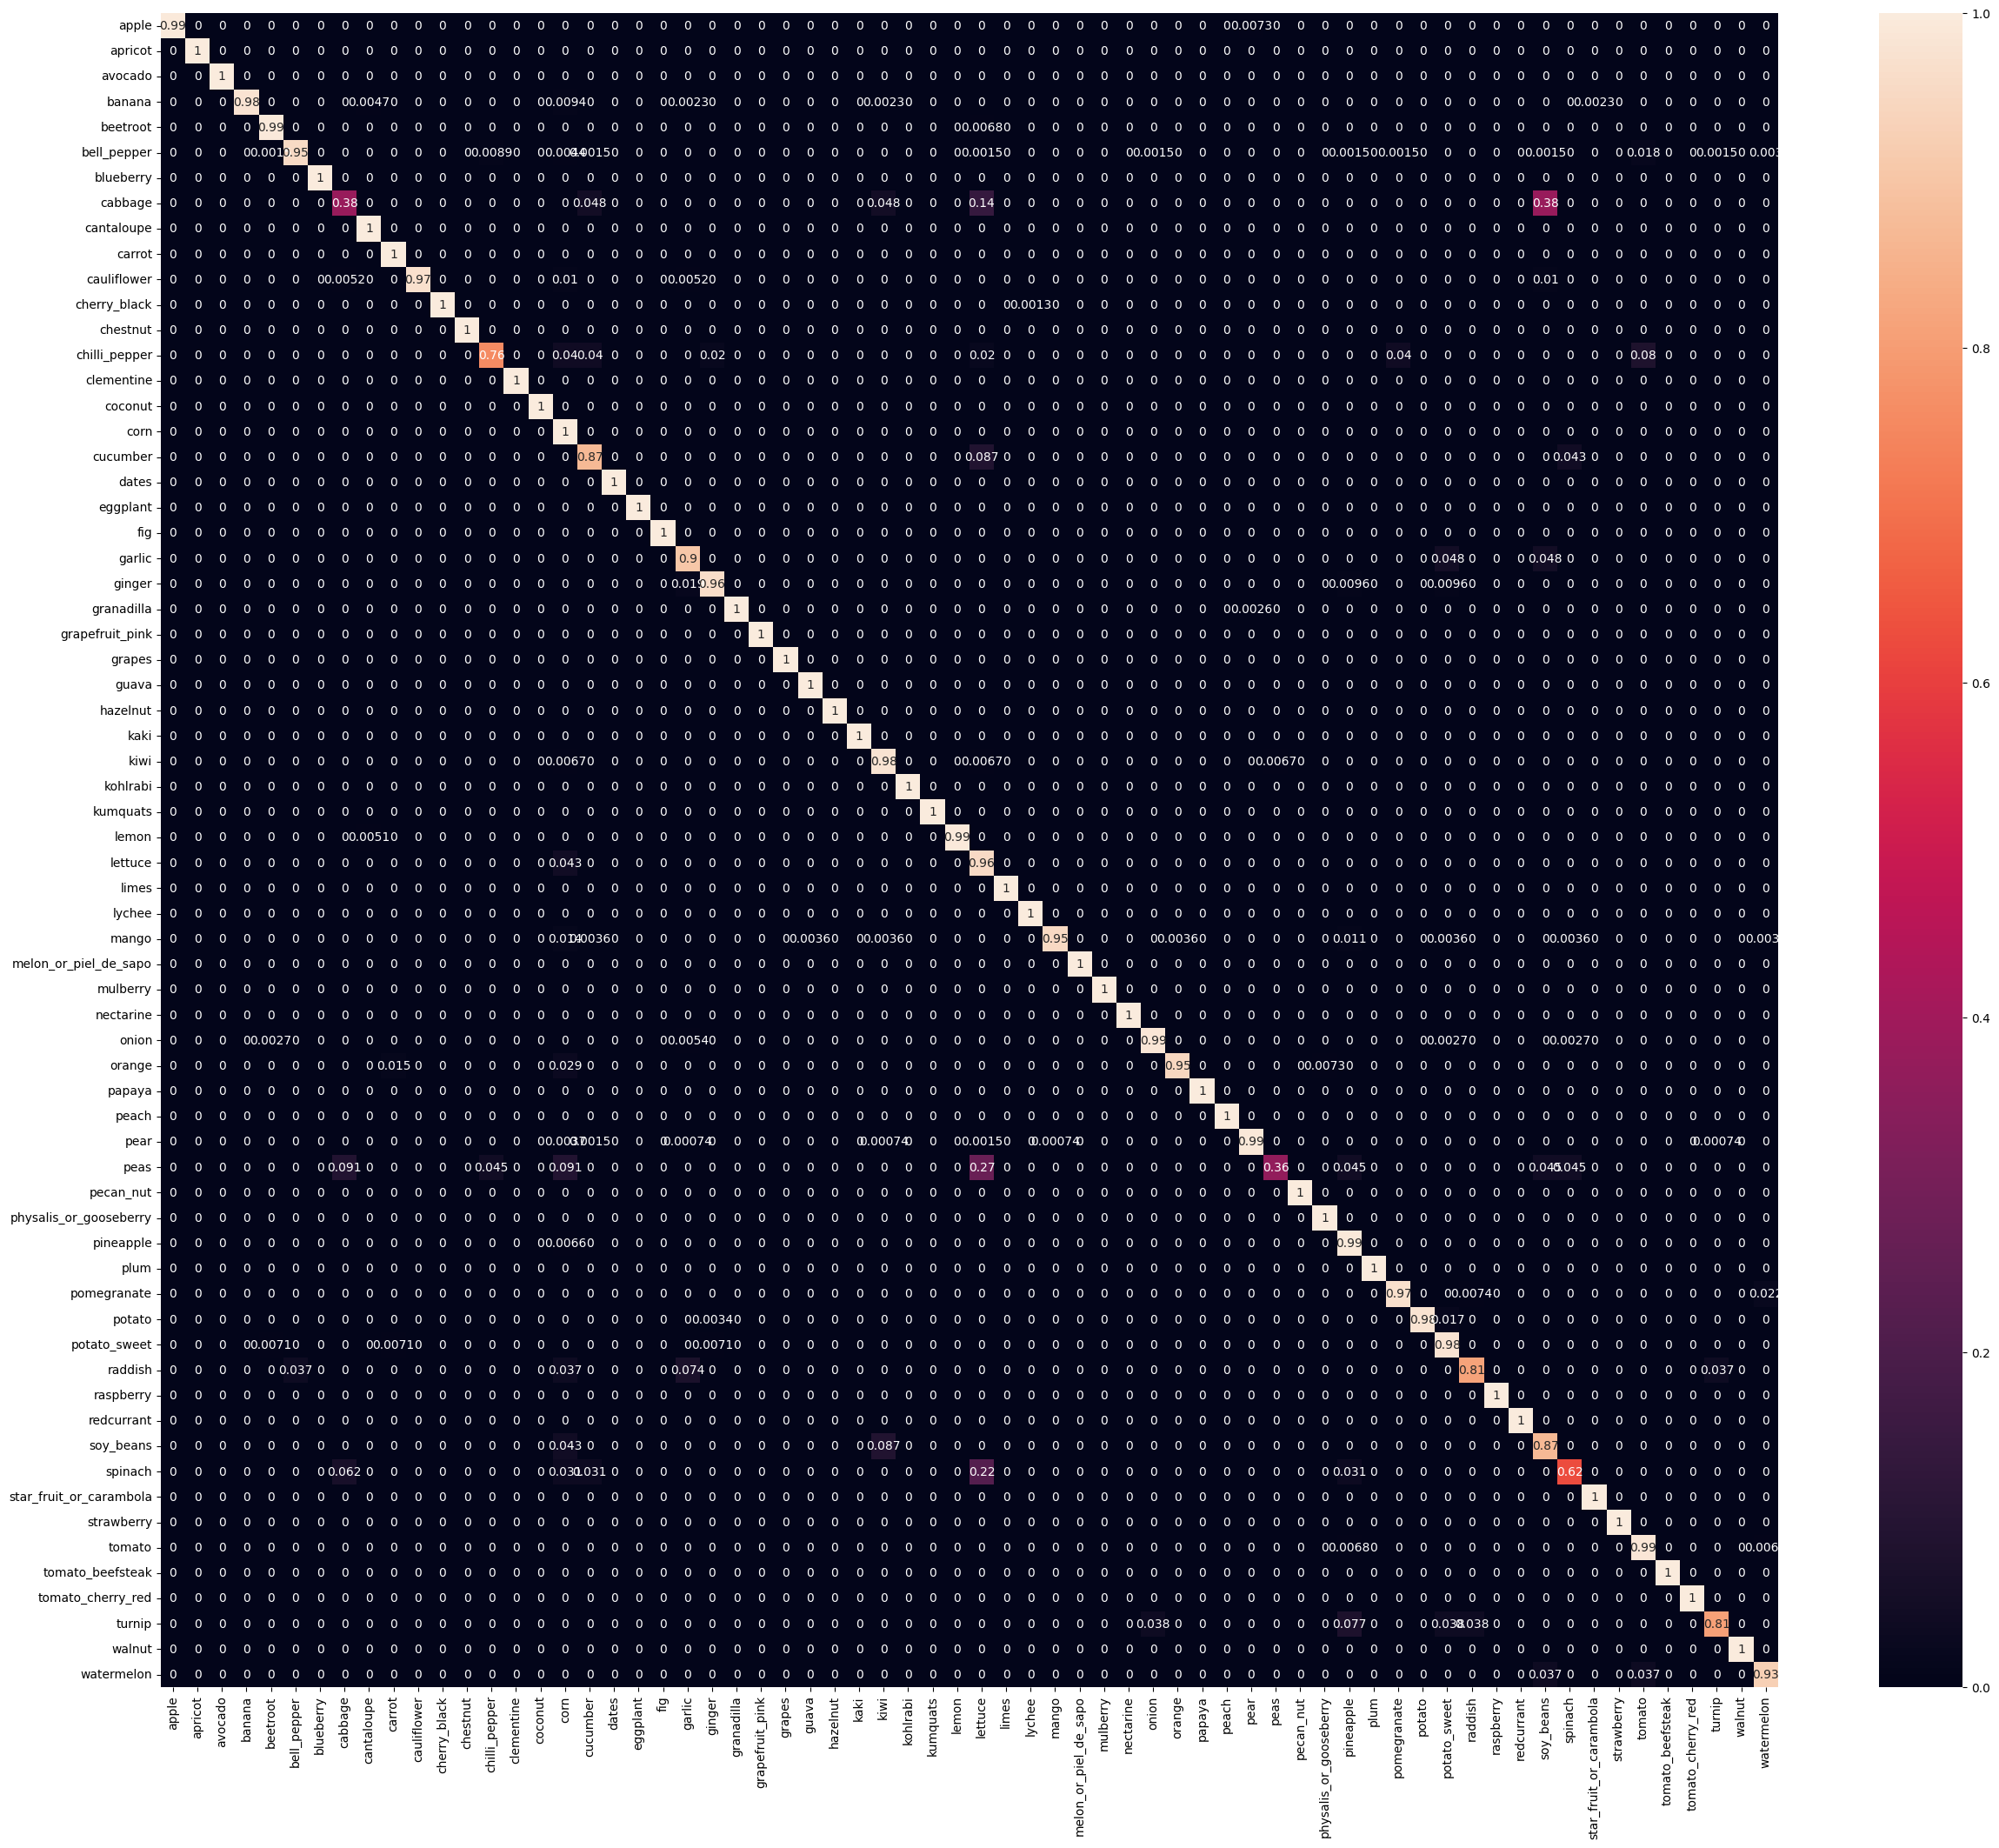

In [14]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
classes = dataset.class_to_idx.keys()
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize=(30, 25))
sn.heatmap(df_cm, annot=True)
plt.savefig(f'CV_data/conf_matrix/{model_name}-output.pdf')

# Test examples

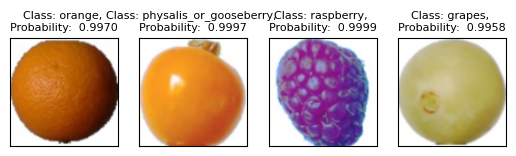

In [15]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

NUM_IMG = 4
fig, axs = plt.subplots(1, NUM_IMG)
imgs = []
classes = []

for idx in range(NUM_IMG):
    nhwc_img = np.transpose(features[idx], axes=(1, 2, 0))
    imgs.append(nhwc_img)

    model.eval()
    _ , probas = model(features.to(device)[idx, None])
    probas = probas.cpu().detach().numpy()

    classes.append(
        {"class": idx_to_class[np.argmax(probas[0])],
         "proba": np.max(probas[0])})

for i, ax in enumerate(axs.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.set_title(f'Class: {classes[i]["class"]}, \nProbability:  {classes[i]["proba"]:.4f}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])


# Own photos

In [13]:
import os
path = "CV_data/own_photos/"
path = "CV_data/own_photos_no_background/"
classes = os.listdir(path)
classes = [fldr for fldr in classes if not fldr.startswith('.')]

print(classes)

transform = transforms.Compose([
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor()
])

custom_test_dataset = datasets.ImageFolder(root=path, transform=transform)
# custom_test_dataset = datasets.Subset(custom_test_dataset, [custom_test_dataset.class_to_idx[c] for c in classes])

custom_test_loader = DataLoader(dataset=custom_test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)


['mango', 'banana', 'apple']


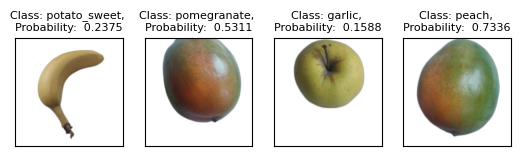

In [15]:
for batch_idx, (features, targets) in enumerate(custom_test_loader):

    features = features
    targets = targets
    break

NUM_IMG = 4
fig, axs = plt.subplots(1, NUM_IMG)
imgs = []
classes = []

for idx in range(NUM_IMG):
    nhwc_img = np.transpose(features[idx], axes=(1, 2, 0))
    imgs.append(nhwc_img)

    model.eval()
    _ , probas = model(features.to(device)[idx, None])
    probas = probas.cpu().detach().numpy()

    classes.append(
        {"class": idx_to_class[np.argmax(probas[0])],
         "proba": np.max(probas[0])})

for i, ax in enumerate(axs.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.set_title(f'Class: {classes[i]["class"]}, \nProbability:  {classes[i]["proba"]:.4f}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

In [19]:
from lib.nutrifacts import retrieve_nutrition_facts
import json

from IPython.core.display import HTML
HTML("&micro;")

print(json.dumps(retrieve_nutrition_facts(classes[2]["class"]), indent=4))

{'Food_Group': 'Vegetables', 'Food Name': 'Turnip tops raw', 'Energy(kcal)': 17, 'Water(g)': '94', 'Protein(g)': '2', 'Fat(g)': '0', 'Fatty_acids_total(g)': '0', 'Fatty acids saturated total(g)': '0', 'Carbohydrate(g)': '1', 'Sugar(g)': '0', 'Starch(g)': '1', 'Fiber dietary total(g)': '2,3', 'Na(mg)': 40.0, 'K(mg)': 296.0, 'Ca(mg)': 100.0, 'P(mg)': 45.0, 'Mg(mg)': 10.0, 'Fe(mg)': '3', 'Cu(mg)': '0,09', 'Se(µg)': nan, 'Zn(mg)': '0,4', 'Id(µg)': '2', 'Vitamin_D(µg)': '0', 'Vitamin_E(mg)': '0', 'Vitamin_K(µg)': '251', 'Vitamin_B1(mg)': '0,05', 'Vitamin_B2(mg)': '0,15', 'Vitamin_B6(mg)': '0,09', 'Vitamin_B12(µg)': '0', 'Vitamin_B3(mg)': '0,8', 'Vitamin_C(mg)': 35.0, 'Vitamin_A': 7011.0}
{
    "Food Name": "Turnip tops raw",
    "Energy(kcal)": 17,
    "Water(g)": 94.0,
    "Protein(g)": 2.0,
    "Carbohydrate(g)": 1.0,
    "Starch(g)": 1.0,
    "Fiber dietary total(g)": 2.3,
    "Na(mg)": 40.0,
    "K(mg)": 296.0,
    "Ca(mg)": 100.0,
    "P(mg)": 45.0,
    "Mg(mg)": 10.0,
    "Fe(mg)": 3.